In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import shap
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor # RMSE 
from sklearn.metrics import mean_squared_error

In [4]:
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)

# Data Dictionary

## KP Column 설명
- RECV_DEPT_NM : 접수부서 코드 ☆
- RECV_CPLT_DM : 접수완료 일시
- NPA_CL : 경찰청 구분 ☆
- EVT_STAT_CD : 사건 상태 코드
- EVT_CL_CD : 사건종별코드
- RPTER_SEX : 신고 성별 (남 : 1 / 여 : 2 / 불상 : 3)
- HPPN_PNU_ADDR : 발생지점(PNU)
- HPPN_X : 발생좌표X
- HPPN_Y : 발생좌표Y
- SME_EVT_YN : 동일사건여부 

## NPA Column 설명
- RECV_CPLT_DT : 접수완료일자
- RECV_CPLT_TM : 접수완료시간
- NPA_CL : 경찰청 구분 ☆
- EVT_STAT_CD : 사건 상태 코드
- EVT_CL_CD : 사건종별코드
- RPTER_SEX : 신고 성별 (남 : 1 / 여 : 2 / 불상 : 3)
- HPPN_PNU_ADDR : 발생지점(PNU)
- HPPN_X : 발생좌표X
- HPPN_Y : 발생좌표Y
- SME_EVT_YN : 동일사건여부 

In [94]:
KP2020 = pd.read_csv("./KP2020.csv", encoding = 'cp949')
KP2020

,RECV_DEPT_NM,RECV_CPLT_DM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_PNU_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,충남청,20/12/01 01:43:07.000000000,19,10,305,1.0,충청남도 보령시 궁촌동(행정:대천4동) 369,126.598345,36.341537,Y
1,대전청,20/12/01 02:05:04.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
2,대전청,20/12/01 02:06:52.000000000,13,10,601,1.0,NaN,127.404663,36.341685,NaN
3,충남청,20/12/01 02:37:25.000000000,19,10,606,3.0,충청남도 보령시 천북면 하만리 628-10,126.524980,36.474390,N
4,충남청,20/12/01 08:17:50.000000000,19,10,401,2.0,충청남도 천안시 서북구 성정동(행정:성정2동) 1259,127.137160,36.826718,NaN
...,...,...,...,...,...,...,...,...,...,...
77072,충남청,20/12/31 01:18:16.000000000,19,10,302,2.0,충청남도 보령시 주교면 주교리(행정:주교면) 191-6,126.571002,36.387791,NaN
77073,충남청,20/12/31 01:17:45.000000000,19,10,501,3.0,NaN,NaN,NaN,NaN
77074,충남청,20/12/31 00:13:50.000000000,19,10,604,3.0,충청남도 아산시 온천동(행정:온양1동) 1498,127.000391,36.788411,NaN
77075,대전청,20/12/31 00:49:29.000000000,13,10,302,2.0,대전광역시 서구 갈마동(행정:갈마2동) 975,127.373351,36.348051,Y


In [95]:
KP2021 = pd.read_csv("./KP2021.csv", encoding = 'cp949')
KP2021

,RECV_DEPT_NM,RECV_CPLT_DM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_PNU_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,대전청,21/03/07 00:00:01.000000000,13,10,604,3.0,대전광역시 서구 둔산동 1122,127.373676,36.350975,Y
1,대전청,21/03/07 00:02:13.000000000,13,10,201,1.0,대전광역시 유성구 상대동(원신흥동) 469-9,127.339018,36.347420,NaN
2,대전청,21/03/07 00:00:33.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
3,대전청,21/03/07 00:01:18.000000000,13,10,601,3.0,NaN,127.404663,36.341685,NaN
4,대전청,21/03/07 00:01:43.000000000,13,10,308,1.0,대전광역시 중구 선화동 141-16,127.420455,36.330413,NaN
...,...,...,...,...,...,...,...,...,...,...
2594055,대전청,23/01/12 11:23:09.000000000,13,10,104,1.0,대전광역시 유성구 봉명동 (행정:원신흥동 ) 1016-7,127.344600,36.352272,NaN
2594056,충남청,23/01/16 11:59:47.000000000,19,10,307,2.0,충청남도 서산시 음암면 부장리(음암면 ) 560-4,126.514047,36.785626,NaN
2594057,충남청,23/01/16 11:58:54.000000000,19,10,601,3.0,NaN,NaN,NaN,NaN
2594058,충남청,23/01/14 01:00:47.000000000,19,10,601,3.0,NaN,NaN,NaN,NaN


In [96]:
NPA2020 = pd.read_csv("./NPA2020.csv", encoding = 'cp949')
NPA2020

,RECV_CPLT_DT,RECV_CPLT_TM,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_OLD_ADDR,HPPN_X,HPPN_Y,SME_EVT_YN
0,20200101,7,13,10,501,2,대전광역시 중구 목동(행정:목동) 360,127.409270,36.333010,Y
1,20200101,132,13,10,501,1,대전광역시 중구 대흥동(대흥동) 499-1,127.421295,36.325575,NaN
2,20200101,39,13,10,501,1,NaN,127.404663,36.341685,NaN
3,20200101,110,13,10,601,3,NaN,0.000000,0.000000,NaN
4,20200101,342,13,10,601,1,NaN,127.404663,36.341685,NaN
...,...,...,...,...,...,...,...,...,...,...
1178239,20201122,3505,19,10,501,1,,NaN,NaN,
1178240,20201122,5213,13,10,601,,,127.404663,36.341685,
1178241,20201122,4627,19,10,601,1,,NaN,NaN,Y
1178242,20201122,5246,19,5,301,1,충청남도 보령시 신흑동(행정:대천5동),126.516040,36.305619,


In [8]:
NPA2020['NPA_CL'].unique

<bound method Series.unique of 0          13
1          13
2          13
3          13
4          13
           ..
1178239    19
1178240    13
1178241    19
1178242    19
1178243    13
Name: NPA_CL, Length: 1178244, dtype: int64>

In [9]:
KP2020.isna().sum()

RECV_DEPT_NM         0
RECV_CPLT_DM         0
NPA_CL               0
EVT_STAT_CD          0
EVT_CL_CD            0
RPTER_SEX         2419
HPPN_PNU_ADDR    29272
HPPN_X           16764
HPPN_Y           16764
SME_EVT_YN       63635
dtype: int64

In [10]:
KP2021.isna().sum()

RECV_DEPT_NM           0
RECV_CPLT_DM           0
NPA_CL                 0
EVT_STAT_CD            0
EVT_CL_CD              0
RPTER_SEX          23894
HPPN_PNU_ADDR    1072094
HPPN_X            694401
HPPN_Y            694401
SME_EVT_YN       2079123
dtype: int64

In [11]:
NPA2020.isna().sum()

RECV_CPLT_DT          0
RECV_CPLT_TM          0
NPA_CL                0
EVT_STAT_CD           0
EVT_CL_CD             0
RPTER_SEX             0
HPPN_OLD_ADDR    258593
HPPN_X           101653
HPPN_Y           101653
SME_EVT_YN       596801
dtype: int64

- RECV_DEPT_NM : 버려도 될 듯
- RPTER_SEX : INT(FLOAT)로 통일
- HPPN_PNU_ADDR : 버려도 될 듯
- SEX : NAN값 -> 3으로 바꾸기

- HPPN_X, HPPN_Y : 위도 경도 결측치 →  버리기
- SME_EVT_YN : 결측치 N으로 바꾸기 - 1명

- RECV_CPLT_DT, RECV_CPLT_TM : 년도 / 월 / 일 / 시 / 분 / 초 단위로 나누기 - 1명 
- RECV_CPLT_DM : 년도 / 월 / 일 / 시 / 분 / 초 단위로 나누기
- 신무진

- EVT_CL_CD : 종별 코드 → 보이스피싱 / 교통사고 분류 : 4인거만 찾아내기 - 1명 해버림

![nn](./KakaoTalk_20230204_155422740.png)

In [97]:
x = NPA2020[NPA2020['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
NPA2020 = y

x = KP2021[KP2021['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
KP2021 = y

x = KP2020[KP2020['EVT_CL_CD'] < 500]
y = x[x['EVT_CL_CD'] > 400]
KP2020 = y

KP2020.drop('RECV_DEPT_NM', axis = 1, inplace = True)
KP2021.drop('RECV_DEPT_NM', axis = 1, inplace = True)
KP2020.drop('HPPN_PNU_ADDR', axis = 1, inplace = True)
KP2021.drop('HPPN_PNU_ADDR', axis = 1, inplace = True)
NPA2020.drop('HPPN_OLD_ADDR', axis = 1, inplace = True)
#드롭

NPA2020 = NPA2020.drop([42819, 250145, 551827, 609589, 659384, 767378, 802443, 838056, 1044961])

NPA2020["RPTER_SEX"] = NPA2020["RPTER_SEX"].fillna(3).astype(int)
KP2020["RPTER_SEX"] = KP2020["RPTER_SEX"].fillna(3).astype(int)
KP2021["RPTER_SEX"] = KP2021["RPTER_SEX"].fillna(3).astype(int)

#SEX : NAN값 -> 3으로 바꾸기

In [98]:
KP2020['RECV_CPLT_DM'] = KP2020['RECV_CPLT_DM'].astype(str)

def add_20(a):
    return '20'+ a

KP2020['TIME'] = KP2020['RECV_CPLT_DM'].apply(add_20)

# 년
KP2020['YEAR'] =  pd.to_datetime(KP2020['TIME']).dt.year

# 월
KP2020['MONTH'] =  pd.to_datetime(KP2020['TIME']).dt.month

# 일
KP2020['DAY'] =  pd.to_datetime(KP2020['TIME']).dt.day

# 시
KP2020['HOUR'] =  pd.to_datetime(KP2020['TIME']).dt.hour

# 분
KP2020['MINUTE'] =  pd.to_datetime(KP2020['TIME']).dt.minute

# 초
KP2020['SECOND'] =  pd.to_datetime(KP2020['TIME']).dt.second

#요일
KP2020['DAY_OF_WEEK'] = pd.to_datetime(KP2020['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
KP2020 = KP2020.drop(['RECV_CPLT_DM','TIME'], axis = 1)

KP2021['RECV_CPLT_DM'] = KP2021['RECV_CPLT_DM'].astype(str)

KP2021['TIME'] = KP2021['RECV_CPLT_DM'].apply(add_20)

# 년
KP2021['YEAR'] =  pd.to_datetime(KP2021['TIME']).dt.year

# 월
KP2021['MONTH'] =  pd.to_datetime(KP2021['TIME']).dt.month

# 일
KP2021['DAY'] =  pd.to_datetime(KP2021['TIME']).dt.day

# 시
KP2021['HOUR'] =  pd.to_datetime(KP2021['TIME']).dt.hour

# 분
KP2021['MINUTE'] =  pd.to_datetime(KP2021['TIME']).dt.minute

# 초
KP2021['SECOND'] =  pd.to_datetime(KP2021['TIME']).dt.second

# 요일
KP2021['DAY_OF_WEEK'] = pd.to_datetime(KP2021['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
KP2021= KP2021.drop(['RECV_CPLT_DM','TIME'], axis = 1)

NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype(str)
NPA2020['RECV_CPLT_DT'].info()

def silce_year(a):
    return a[:4]
def silce_month(a):
    return a[4:6]
def silce_day(a):
    return a[6:]

# 년
NPA2020['YEAR'] = NPA2020['RECV_CPLT_DT'].apply(silce_year)
NPA2020['YEAR']
# 월
NPA2020['MONTH'] = NPA2020['RECV_CPLT_DT'].apply(silce_month)
NPA2020['MONTH']
# 일
NPA2020['DAY'] = NPA2020['RECV_CPLT_DT'].apply(silce_day)
NPA2020['DAY']

NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype(str)

def add_00(a):
    if len(a) == 6:
        return a
    elif len(a) == 5:
        return '0' + a
    elif len(a) == 4:
        return '0' * 2 + a
    elif len(a) == 3:
        return '0' * 3 + a
    elif len(a) == 2:
        return '0' * 4 + a
    else:
        return '0' * 5 + a

NPA2020['TIME'] = NPA2020['RECV_CPLT_TM'].apply(add_00)

def silce_hour(a):
    return a[:2]

def silce_min(a):
    return a[2:4]

def silce_sec(a):
    return a[4:]

# 시
NPA2020['HOUR'] = NPA2020['TIME'].apply(silce_hour)
NPA2020['HOUR']

# 분
NPA2020['MINUTE'] = NPA2020['TIME'].apply(silce_min)
NPA2020['MINUTE']

# 초
NPA2020['SECOND'] = NPA2020['TIME'].apply(silce_sec)
NPA2020['SECOND']

# 요일
NPA2020['TIME'] = NPA2020['YEAR'] + NPA2020['MONTH'] + NPA2020['DAY']
NPA2020['DAY_OF_WEEK'] = pd.to_datetime(NPA2020['TIME']).dt.day_name()

# 원래 시간 컬럼 삭제
NPA2020 = NPA2020.drop(['TIME', 'RECV_CPLT_TM', 'RECV_CPLT_DT'], axis = 1)

<class 'pandas.core.series.Series'>
Int64Index: 142919 entries, 38 to 1178234
Series name: RECV_CPLT_DT
Non-Null Count   Dtype 
--------------   ----- 
142919 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB


In [99]:
# 위도, 경도 결측치 행 제거
KP2020 = KP2020.dropna(subset = ['HPPN_X','HPPN_Y'])
KP2021 = KP2021.dropna(subset = ['HPPN_X','HPPN_Y'])
NPA2020 = NPA2020.dropna(subset = ['HPPN_X','HPPN_Y'])

# 결측치 N으로 바꾸기
KP2020['SME_EVT_YN'] = KP2020['SME_EVT_YN'].fillna('N')
KP2021['SME_EVT_YN'] = KP2021['SME_EVT_YN'].fillna('N')
NPA2020['SME_EVT_YN'] = NPA2020['SME_EVT_YN'].fillna('N')

def N_rep(x):
    if x == ' ':
        return 'N'
    else:
        return x

NPA2020['SME_EVT_YN'] = NPA2020['SME_EVT_YN'].apply(N_rep)
NPA2020['SME_EVT_YN']

38         N
41         N
54         N
66         N
117        N
          ..
1178083    N
1178086    Y
1178143    N
1178173    Y
1178234    N
Name: SME_EVT_YN, Length: 140958, dtype: object

In [100]:
NPA2020

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
38,13,10,402,1,127.386346,36.346856,N,2020,01,01,00,32,40,Wednesday
41,13,10,406,1,127.349989,36.360797,N,2020,01,01,00,35,32,Wednesday
54,13,10,401,1,127.348625,36.353829,N,2020,01,01,00,21,35,Wednesday
66,13,10,401,1,127.405055,36.328573,N,2020,01,01,00,43,01,Wednesday
117,13,10,401,3,127.445780,36.345500,N,2020,01,01,18,43,35,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday
1178086,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday
1178143,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday
1178173,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday


In [101]:
KP2021

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
14,19,10,406,1,127.107500,36.811944,N,2021,3,7,0,2,48,Sunday
20,19,10,402,1,127.150988,36.811792,Y,2021,3,7,0,9,4,Sunday
23,13,10,401,2,127.371854,36.341961,N,2021,3,7,0,7,54,Sunday
26,13,10,401,1,127.339334,36.346899,N,2021,3,7,0,15,27,Sunday
44,19,10,403,2,127.090733,36.453397,N,2021,3,7,0,12,8,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593994,13,10,401,1,127.384284,36.334507,N,2023,1,15,20,1,39,Sunday
2594002,19,10,401,1,126.262393,36.751467,N,2023,1,16,21,26,56,Monday
2594006,19,10,403,2,127.147678,36.789125,N,2023,1,14,1,2,48,Saturday
2594019,13,10,401,1,127.433785,36.450725,N,2023,1,14,17,35,38,Saturday


In [102]:
KP2020

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77024,19,10,406,1,126.298968,36.747649,Y,2020,12,31,0,16,14,Thursday
77036,13,10,401,1,127.428343,36.324386,N,2020,12,31,1,8,43,Thursday
77066,19,10,406,1,126.298968,36.747649,Y,2020,12,31,0,26,16,Thursday
77068,13,10,401,1,127.369099,36.312971,N,2020,12,31,1,17,1,Thursday


In [103]:
c = pd.concat([KP2020, KP2021])
data = pd.concat([c, NPA2020])
data

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
4,19,10,401,2,127.137160,36.826718,N,2020,12,1,8,17,50,Tuesday
7,13,10,406,1,127.341551,36.353696,N,2020,12,1,3,24,26,Tuesday
8,19,10,402,1,127.136142,36.917900,N,2020,12,1,7,37,18,Tuesday
9,13,10,401,1,127.447545,36.306724,N,2020,12,1,7,8,44,Tuesday
10,13,10,401,2,127.447175,36.306694,N,2020,12,1,7,9,20,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178083,13,7,406,1,127.404540,36.325219,N,2020,11,22,00,20,07,Sunday
1178086,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,40,08,Sunday
1178143,19,5,406,3,127.107617,36.813773,N,2020,11,22,00,57,19,Sunday
1178173,13,5,401,1,127.446090,36.320140,Y,2020,11,22,00,37,53,Sunday


In [104]:
data.describe()

,NPA_CL,EVT_STAT_CD,EVT_CL_CD,RPTER_SEX,HPPN_X,HPPN_Y
count,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000,426761.000000
mean,17.241625,9.987984,402.125468,1.390434,126.088176,36.242524
std,3.983437,0.235342,1.817076,0.662202,11.461662,3.302529
min,8.000000,2.000000,401.000000,1.000000,0.000000,0.000000
25%,13.000000,10.000000,401.000000,1.000000,127.008599,36.341685
50%,19.000000,10.000000,401.000000,1.000000,127.167879,36.458332
75%,19.000000,10.000000,402.000000,2.000000,127.379848,36.787168
max,31.000000,10.000000,406.000000,3.000000,129.435259,38.211177


In [105]:
data.describe(include=['O']) #범주형 데이터 확인

,SME_EVT_YN,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,DAY_OF_WEEK
count,426761,426761,426761,426761,426761,426761,426761,426761
unique,2,5,23,62,48,120,120,7
top,N,2020,12,14,18,16,50,Saturday
freq,346144,140958,32226,9728,20131,4938,4943,68027


In [106]:
data['YEAR'] = data['YEAR'].astype(int)
data['MONTH'] = data['MONTH'].astype(int)
data['DAY'] = data['DAY'].astype(int)
data['HOUR'] = data['HOUR'].astype(int)
data['MINUTE'] = data['MINUTE'].astype(int)
data['SECOND'] = data['SECOND'].astype(int)

In [107]:
acc401 = data[data['EVT_CL_CD'] == 401] # 교통사고
acc402 = data[data['EVT_CL_CD'] == 402] # 교통불편
acc403 = data[data['EVT_CL_CD'] == 403] # 교통위반
acc404 = data[data['EVT_CL_CD'] == 404] # 사망, 대형사고
acc405 = data[data['EVT_CL_CD'] == 405] # 인피도주 (뺑소니)
acc406 = data[data['EVT_CL_CD'] == 406] # 음주운전

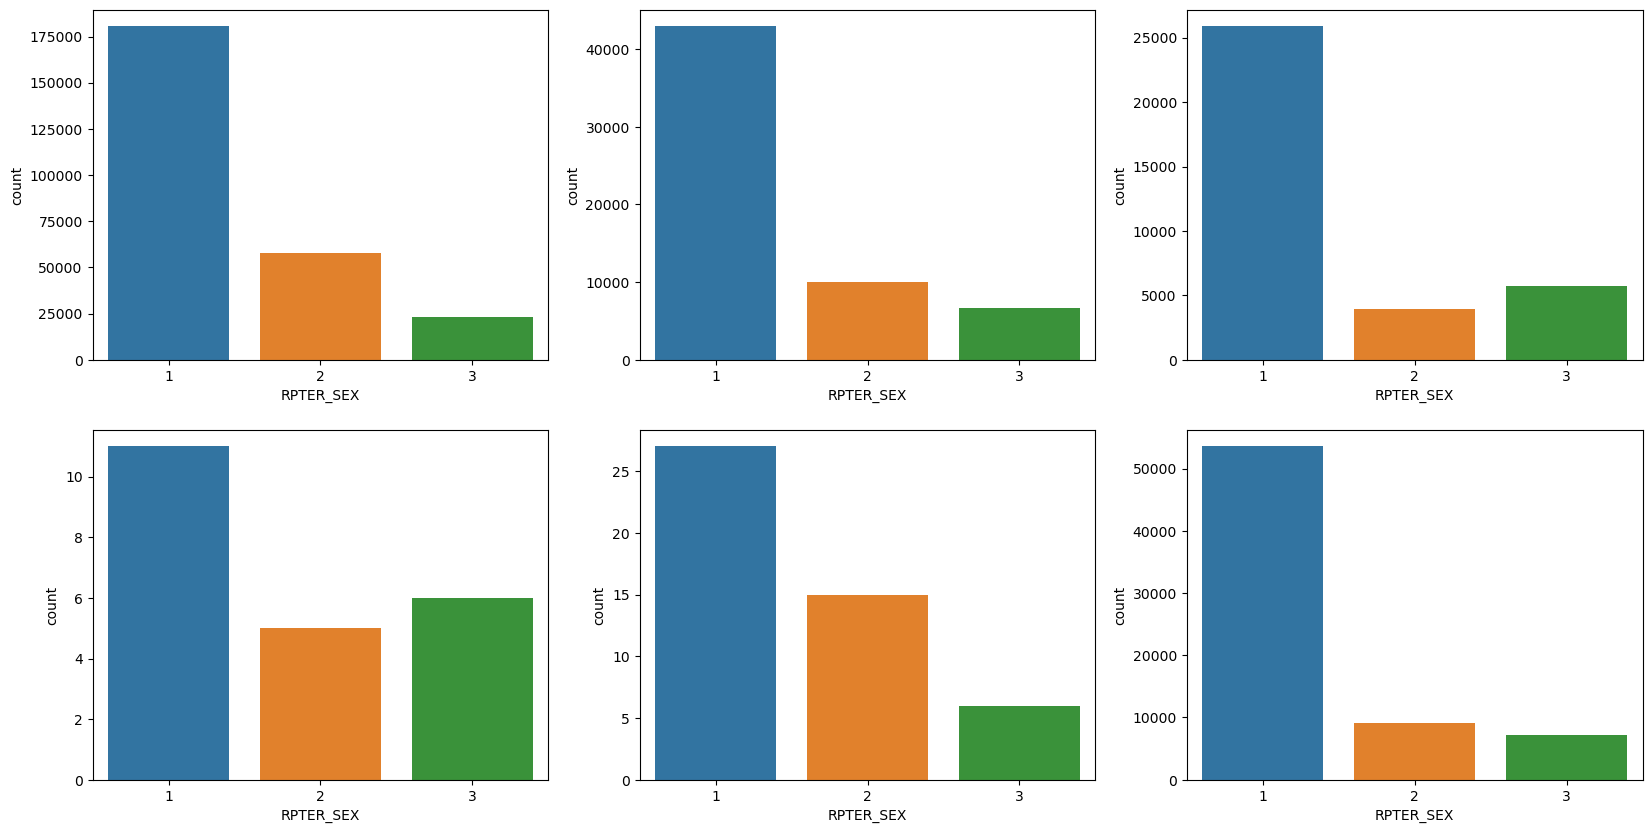

In [108]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="RPTER_SEX", data=acc401, ax = axes[0])
ax = sns.countplot(x="RPTER_SEX", data=acc402, ax = axes[1])
ax = sns.countplot(x="RPTER_SEX", data=acc403, ax = axes[2])
ax = sns.countplot(x="RPTER_SEX", data=acc404, ax = axes[3])
ax = sns.countplot(x="RPTER_SEX", data=acc405, ax = axes[4])
ax = sns.countplot(x="RPTER_SEX", data=acc406, ax = axes[5])

plt.show()

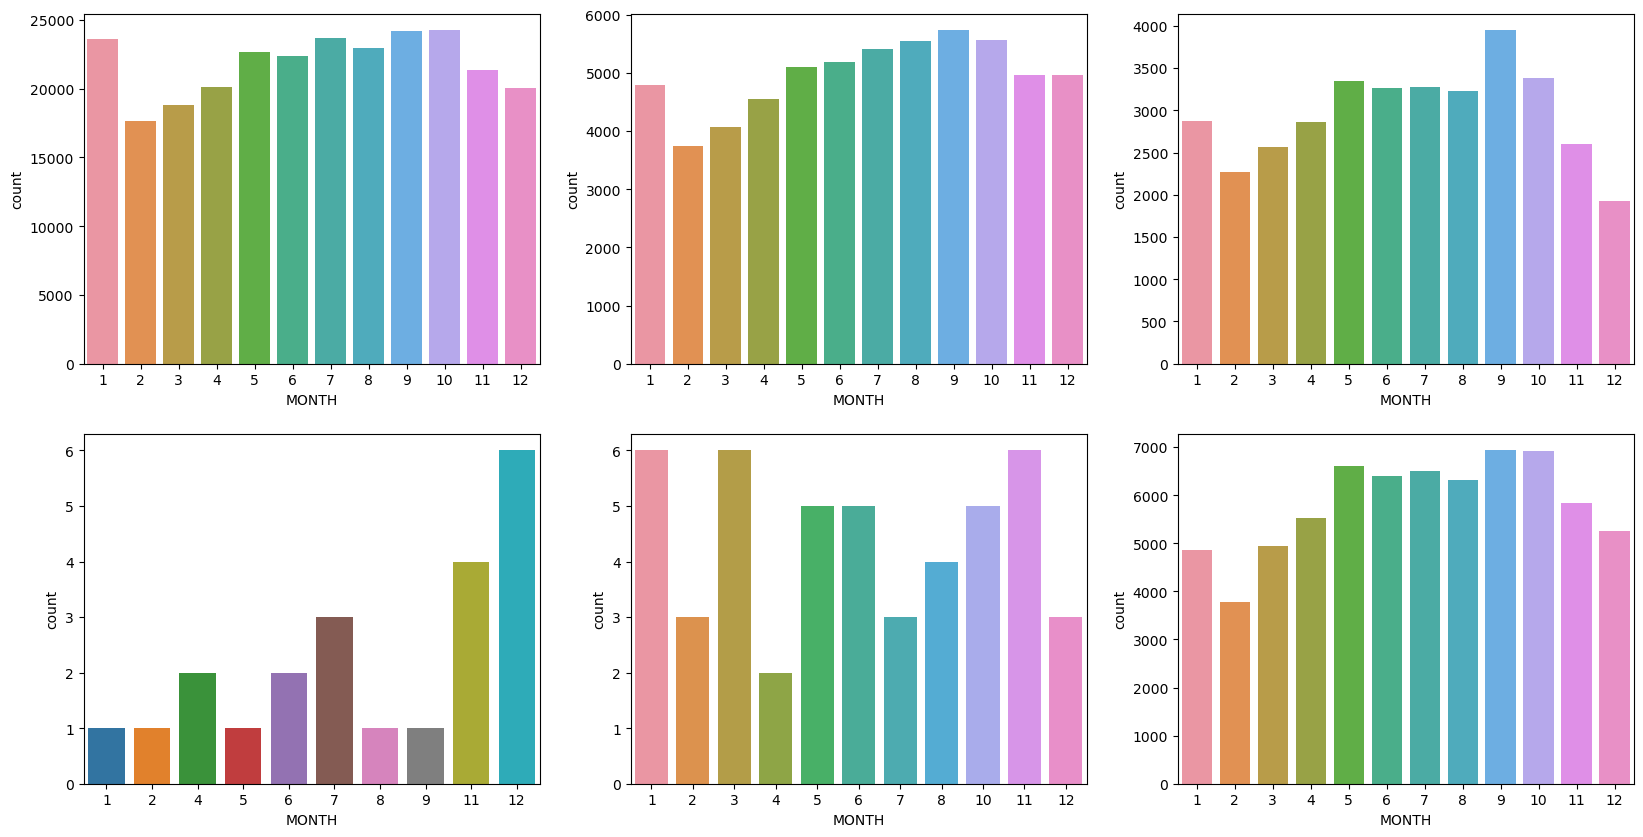

In [109]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="MONTH", data=acc401, ax = axes[0])
ax = sns.countplot(x="MONTH", data=acc402, ax = axes[1])
ax = sns.countplot(x="MONTH", data=acc403, ax = axes[2])
ax = sns.countplot(x="MONTH", data=acc404, ax = axes[3])
ax = sns.countplot(x="MONTH", data=acc405, ax = axes[4])
ax = sns.countplot(x="MONTH", data=acc406, ax = axes[5])

plt.show()

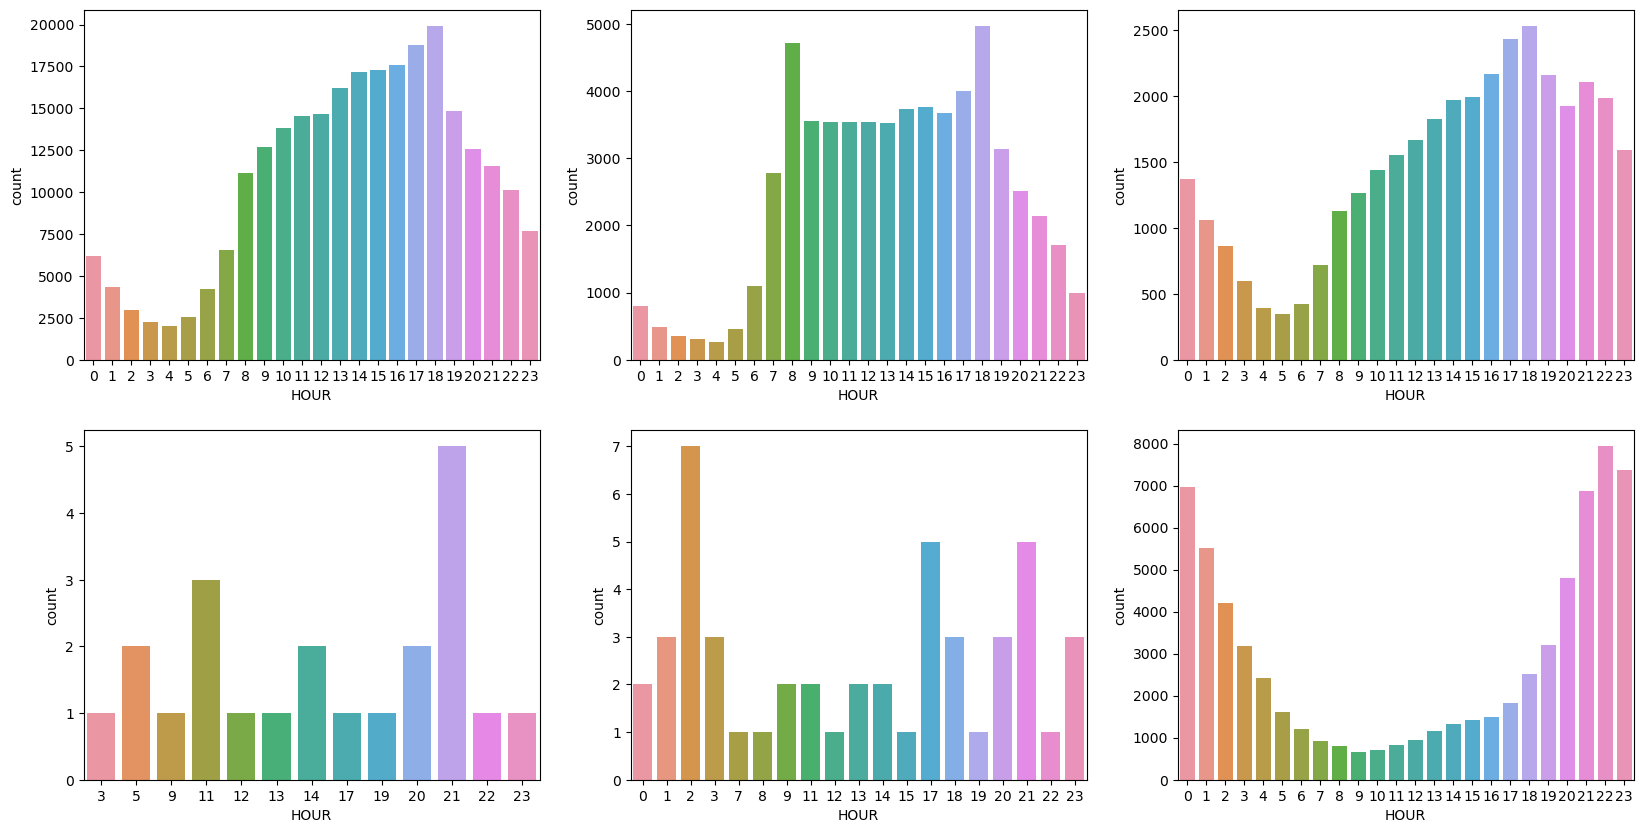

In [110]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(20,10)

ax = sns.countplot(x="HOUR", data=acc401, ax = axes[0])
ax = sns.countplot(x="HOUR", data=acc402, ax = axes[1])
ax = sns.countplot(x="HOUR", data=acc403, ax = axes[2])
ax = sns.countplot(x="HOUR", data=acc404, ax = axes[3])
ax = sns.countplot(x="HOUR", data=acc405, ax = axes[4])
ax = sns.countplot(x="HOUR", data=acc406, ax = axes[5])

plt.show()

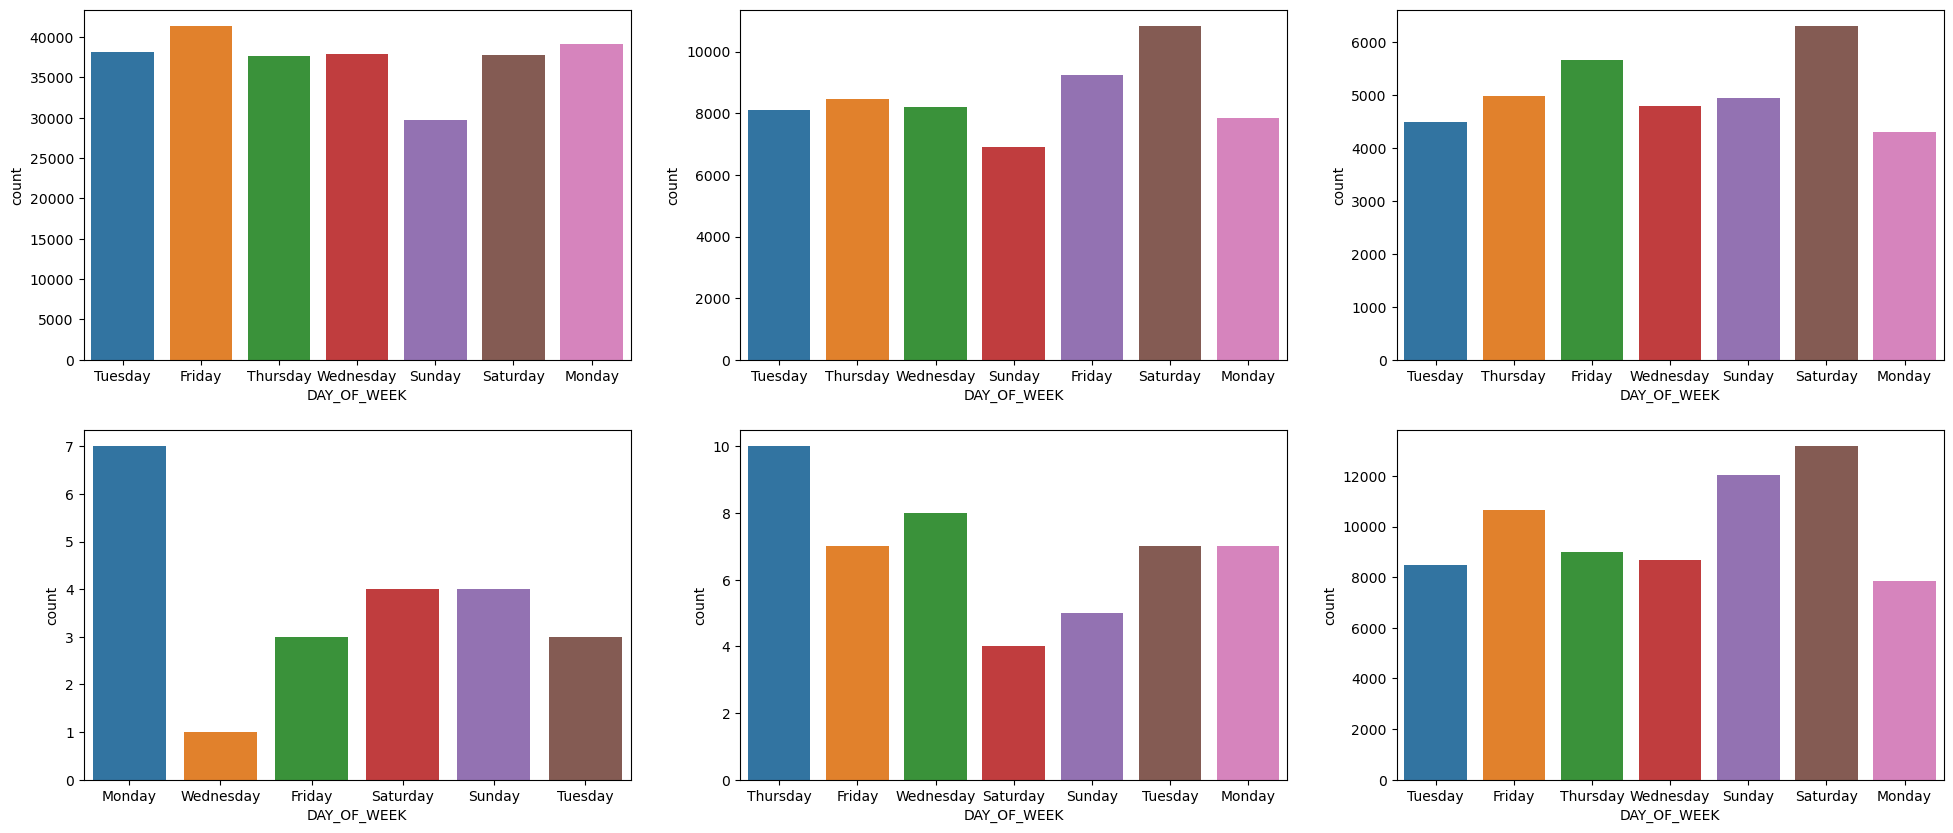

In [112]:
f , axes = plt.subplots(2,3)
axes = axes.flatten()
f.set_size_inches(24,10)

ax = sns.countplot(x="DAY_OF_WEEK", data=acc401, ax = axes[0])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc402, ax = axes[1])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc403, ax = axes[2])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc404, ax = axes[3])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc405, ax = axes[4])
ax = sns.countplot(x="DAY_OF_WEEK", data=acc406, ax = axes[5])

plt.show()

In [123]:
data['EVT_STAT_CD'].value_counts()

10    425879
Name: EVT_STAT_CD, dtype: int64

In [117]:
data.loc[data.EVT_STAT_CD == 7,'EVT_STAT_CD'] = 10

In [122]:
data.drop(data.loc[data.EVT_STAT_CD == 9].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 3].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 2].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 6].index, inplace = True)
data.drop(data.loc[data.EVT_STAT_CD == 5].index, inplace = True)